# 라이브러리 설치 및 불러오기

In [ ]:
!pip install catboost
!pip install optuna
!pip install imbalanced-learn
!pip install lightgbm
!pip install xgboost
!pip install shap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from scipy import stats
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import shap
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# matplotlib에 폰트를 설정합니다.

# matplotlib 라이브러리를 불러옵니다.
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 설치된 폰트 목록을 갱신하고, 'NanumGothic' 폰트를 기본 폰트로 설정합니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글이 깨지지 않도록 하기 위해서 minus 표시를 설정합니다.
plt.rcParams['axes.unicode_minus'] = False

# 데이터 셋

In [ ]:
data = pd.read_feather('/content/drive/MyDrive/Data/lending_club_final2_전체.feather')

In [ ]:
df= data.copy()
# final columns 중 제일 좋았던 조합
columns = ['funded_amnt', 'term', 'int_rate', 'fico_range_high', 'dti', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
           'num_tl_op_past_12m', 'new_purpose', 'new_emp_length', 'new_home_ownership', 'new_verification_status', 'new_state', 'loan_status_N', 'num_op_rev_tl',
           'num_rev_tl_bal_gt_0', 'revol_bal', 'tot_hi_cred_lim', 'mort_acc', 'annual_inc', 'percent_bc_gt_75', 'revol_util']

df_1 = df[columns].copy()

column_mapping = {
    'funded_amnt': '대출 금액',
    'term': '대출 기간 (연)',
    'int_rate': '이자율',
    'fico_range_high': 'Fico 등급',
    'dti': 'DTI',
    'mo_sin_old_il_acct': '가장 오래된 할부 계좌 개월 수',
    'mo_sin_old_rev_tl_op': '가장 오래된 회전 계좌 개월 수',
    'num_tl_op_past_12m': '12개월 내 개설된 계좌 수',
    'new_purpose': '대출 목적',
    'new_emp_length': '근속 연수',
    'new_home_ownership': '주택 소유 상태',
    'new_verification_status': '소득 확인 상태',
    'new_state': '주소',
    'num_op_rev_tl': '개설된 회전 계좌 수',
    'num_rev_tl_bal_gt_0': '리볼빙 계좌 수',
    'revol_bal': '총 리볼빙 잔여 한도',
    'tot_hi_cred_lim': '총 신용/대출 한도',
    'mort_acc': '모기지 계좌 수',
    'annual_inc': '연간 소득',
    'percent_bc_gt_75': '고한도 사용률',
    'revol_util': '신용한도 사용률'
}

df_1.rename(columns=column_mapping, inplace=True)

# 불균형 가중치 계산
scale_pos_weight = df['loan_status_N'].value_counts()[0] / df['loan_status_N'].value_counts()[1]

In [ ]:
# 피쳐, 타겟 분리
df_X = df_1.drop(columns='loan_status_N')
df_y = df_1['loan_status_N']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=1234, stratify=df_y)

df_X.shape, df_y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((422347, 21), (422347,), (337877, 21), (84470, 21), (337877,), (84470,))

## RF

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

최적의 임계값: 0.23
최적 임계값에서의 F1-score: 0.48
최적 임계값에서의 Precision: 0.37
최적 임계값에서의 Recall: 0.70


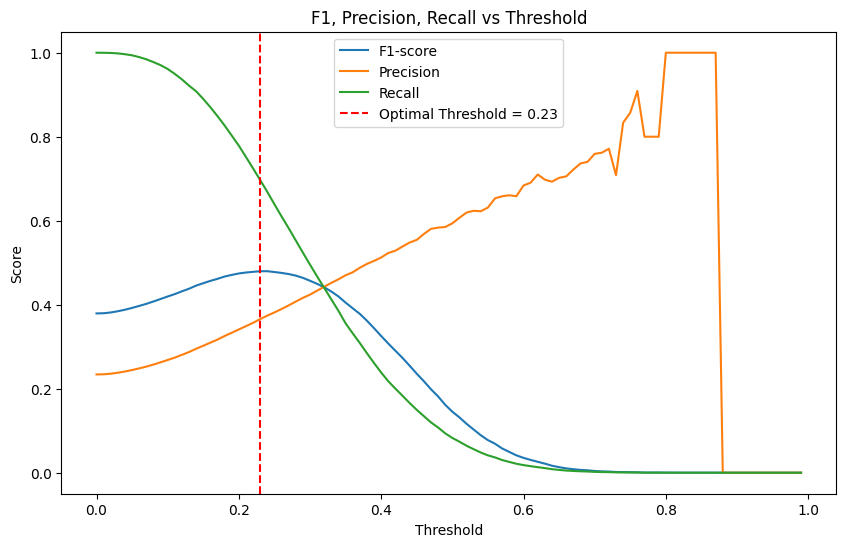

In [ ]:
# 임계값 찾기

rf_model = RandomForestClassifier(random_state=42, n_estimators = 1000, class_weight= 'balanced')
rf_model.fit(X_train, y_train)

# 예측 확률 계산
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
f1_scores = []
precisions = []
recalls = []

# 각 임계값에서 성능 지표 계산
for threshold in thresholds:
    # 임계값에 따른 예측 결과 계산
    rf_test_pred_threshold = (rf_test_proba >= threshold).astype(int)

    # F1, Precision, Recall 계산
    f1 = f1_score(y_test, rf_test_pred_threshold)
    precision = precision_score(y_test, rf_test_pred_threshold)
    recall = recall_score(y_test, rf_test_pred_threshold)

    # 결과 저장
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# F1-score가 최대인 임계값 찾기
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"최적의 임계값: {optimal_threshold:.2f}")
print(f"최적 임계값에서의 F1-score: {f1_scores[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Precision: {precisions[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Recall: {recalls[optimal_idx]:.2f}")

# F1, Precision, Recall을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall vs Threshold')
plt.legend(loc='best')
plt.show()


Train Accuracy: 99.86%
Train f1_score: 99.70%
Train Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    258804
     Class 1       0.99      1.00      1.00     79073

    accuracy                           1.00    337877
   macro avg       1.00      1.00      1.00    337877
weighted avg       1.00      1.00      1.00    337877

Test Accuracy: 64.63%
Test f1_score: 47.98%
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.63      0.73     64702
     Class 1       0.37      0.70      0.48     19768

    accuracy                           0.65     84470
   macro avg       0.62      0.66      0.61     84470
weighted avg       0.75      0.65      0.67     84470

Train ROC AUC: 1.00
Test ROC AUC: 0.72


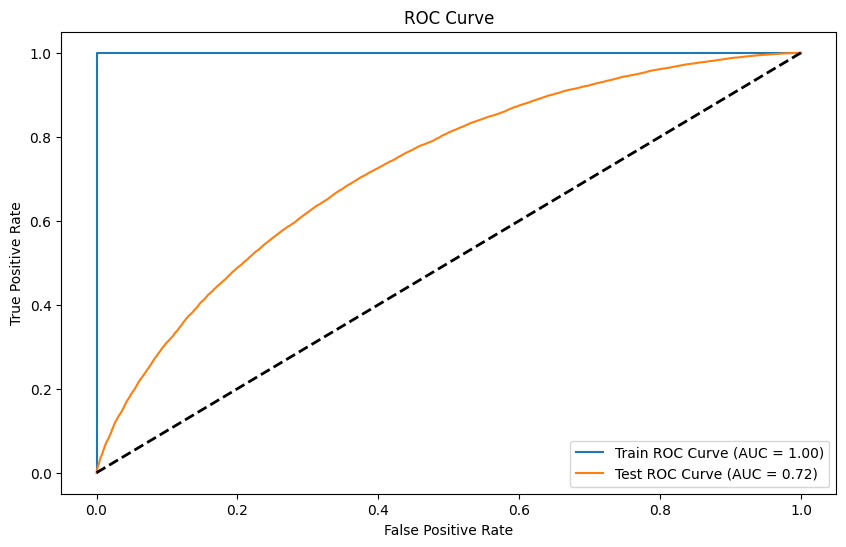

In [ ]:
# 임계값을 조정하여 예측하는 함수
def predict_with_threshold(model, X, threshold=0.5):
    probabilities = model.predict_proba(X)[:, 1]  # 클래스 1에 대한 확률
    return np.where(probabilities >= threshold, 1, 0)

# 임계값 설정 (여기서 원하는 값으로 조정 가능)
threshold = 0.23

# 학습 데이터에 대한 예측
rf_train_pred = predict_with_threshold(rf_model, X_train, threshold)

# 테스트 데이터에 대한 예측
rf_test_pred = predict_with_threshold(rf_model, X_test, threshold)

# 학습 데이터 성능 평가
rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
rf_train_f1 = f1_score(y_train, rf_train_pred)
rf_train_report = classification_report(y_train, rf_train_pred, target_names=['Class 0', 'Class 1'])

print(f"Train Accuracy: {rf_train_accuracy * 100:.2f}%")
print(f"Train f1_score: {rf_train_f1 * 100:.2f}%")
print("Train Classification Report:")
print(rf_train_report)

# 테스트 데이터 성능 평가
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
rf_test_f1 = f1_score(y_test, rf_test_pred)
rf_test_report = classification_report(y_test, rf_test_pred, target_names=['Class 0', 'Class 1'])

print(f"Test Accuracy: {rf_test_accuracy * 100:.2f}%")
print(f"Test f1_score: {rf_test_f1 * 100:.2f}%")
print("Test Classification Report:")
print(rf_test_report)

# ROC AUC 계산
rf_train_auc = roc_auc_score(y_train, rf_model.predict_proba(X_train)[:, 1])
rf_test_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

print(f"Train ROC AUC: {rf_train_auc:.2f}")
print(f"Test ROC AUC: {rf_test_auc:.2f}")

# ROC Curve 시각화
fpr_train, tpr_train, _ = roc_curve(y_train, rf_model.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {rf_train_auc:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {rf_test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## XGBC

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


최적의 임계값: 0.50
최적 임계값에서의 F1-score: 0.49
최적 임계값에서의 Precision: 0.38
최적 임계값에서의 Recall: 0.68


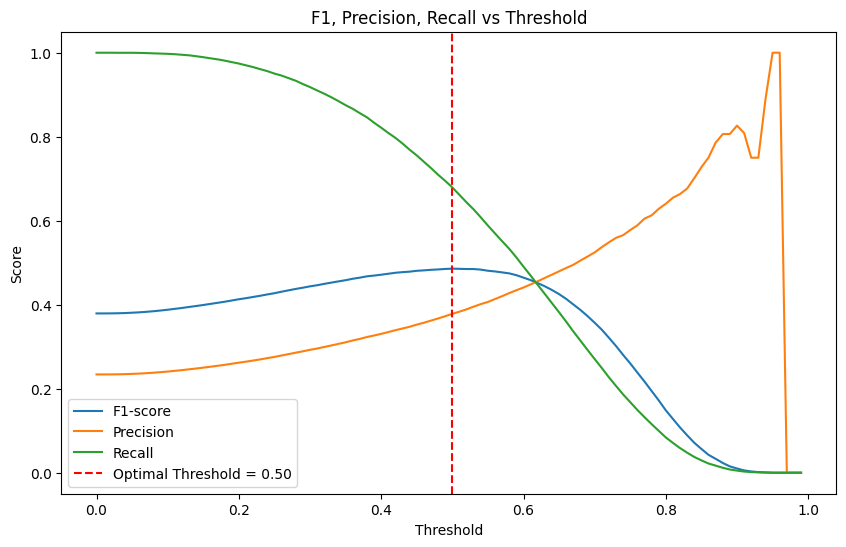

In [ ]:
# XGBoost 모델 학습
xgb_model = XGBClassifier(n_jobs=-1, n_estimators=2000, learning_rate = 0.01 ,scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)

# 예측 확률 계산
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
f1_scores = []
precisions = []
recalls = []

# 각 임계값에서 성능 지표 계산
for threshold in thresholds:
    # 임계값에 따른 예측 결과 계산
    xgb_test_pred_threshold = (xgb_test_proba >= threshold).astype(int)

    # F1, Precision, Recall 계산
    f1 = f1_score(y_test, xgb_test_pred_threshold)
    precision = precision_score(y_test, xgb_test_pred_threshold)
    recall = recall_score(y_test, xgb_test_pred_threshold)

    # 결과 저장
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# F1-score가 최대인 임계값 찾기
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"최적의 임계값: {optimal_threshold:.2f}")
print(f"최적 임계값에서의 F1-score: {f1_scores[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Precision: {precisions[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Recall: {recalls[optimal_idx]:.2f}")

# F1, Precision, Recall을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall vs Threshold')
plt.legend(loc='best')
plt.show()


Train Accuracy: 68.20%
Train f1_score: 51.45%
Train Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.67      0.76    258804
     Class 1       0.40      0.72      0.51     79073

    accuracy                           0.68    337877
   macro avg       0.64      0.70      0.64    337877
weighted avg       0.77      0.68      0.71    337877

Test Accuracy: 66.36%
Test f1_score: 48.59%
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.66      0.75     64702
     Class 1       0.38      0.68      0.49     19768

    accuracy                           0.66     84470
   macro avg       0.62      0.67      0.62     84470
weighted avg       0.76      0.66      0.69     84470

Train ROC AUC: 0.767
Test ROC AUC: 0.732


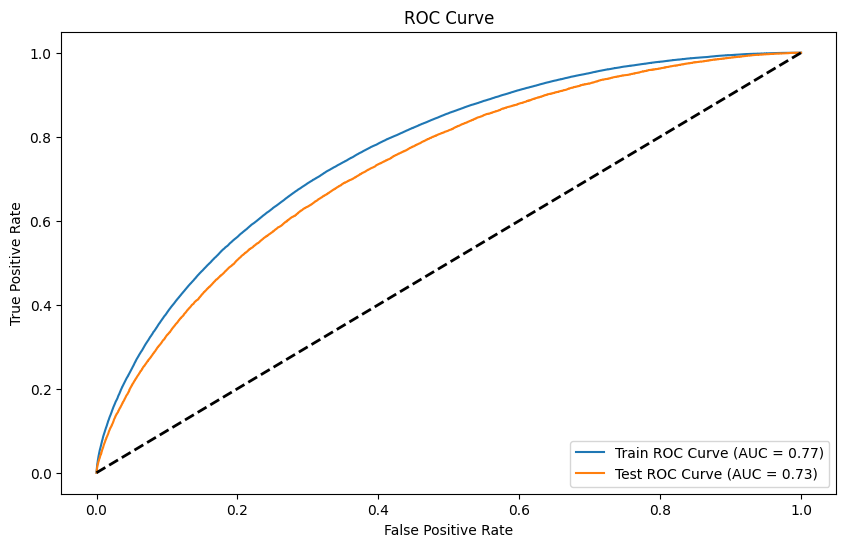

In [ ]:

# 임계값을 조정하여 예측하는 함수
def predict_with_threshold(model, X, threshold=0.5):
    probabilities = model.predict_proba(X)[:, 1]  # 클래스 1에 대한 확률
    return np.where(probabilities >= threshold, 1, 0)

# 임계값 설정 (여기서 원하는 값으로 조정 가능)
threshold = 0.5

# 학습 데이터에 대한 예측
xgb_train_pred = predict_with_threshold(xgb_model, X_train, threshold)

# 테스트 데이터에 대한 예측
xgb_test_pred = predict_with_threshold(xgb_model, X_test, threshold)

# 학습 데이터 성능 평가
xgb_train_accuracy = accuracy_score(y_train, xgb_train_pred)
xgb_train_f1 = f1_score(y_train, xgb_train_pred)
xgb_train_report = classification_report(y_train, xgb_train_pred, target_names=['Class 0', 'Class 1'])

print(f"Train Accuracy: {xgb_train_accuracy * 100:.2f}%")
print(f"Train f1_score: {xgb_train_f1 * 100:.2f}%")
print("Train Classification Report:")
print(xgb_train_report)

# 테스트 데이터 성능 평가
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)
xgb_test_f1 = f1_score(y_test, xgb_test_pred)
xgb_test_report = classification_report(y_test, xgb_test_pred, target_names=['Class 0', 'Class 1'])

print(f"Test Accuracy: {xgb_test_accuracy * 100:.2f}%")
print(f"Test f1_score: {xgb_test_f1 * 100:.2f}%")
print("Test Classification Report:")
print(xgb_test_report)

# ROC AUC 계산
xgb_train_auc = roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:, 1])
xgb_test_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print(f"Train ROC AUC: {xgb_train_auc:.3f}")
print(f"Test ROC AUC: {xgb_test_auc:.3f}")

# ROC Curve 시각화
fpr_train, tpr_train, _ = roc_curve(y_train, xgb_model.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {xgb_train_auc:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {xgb_test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## LGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 79073, number of negative: 258804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2483
[LightGBM] [Info] Number of data points in the train set: 337877, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234029 -> initscore=-1.185700
[LightGBM] [Info] Start training from score -1.185700
최적의 임계값: 0.69
최적 임계값에서의 F1-score: 0.86
최적 임계값에서의 Precision: 0.84
최적 임계값에서의 Recall: 0.88


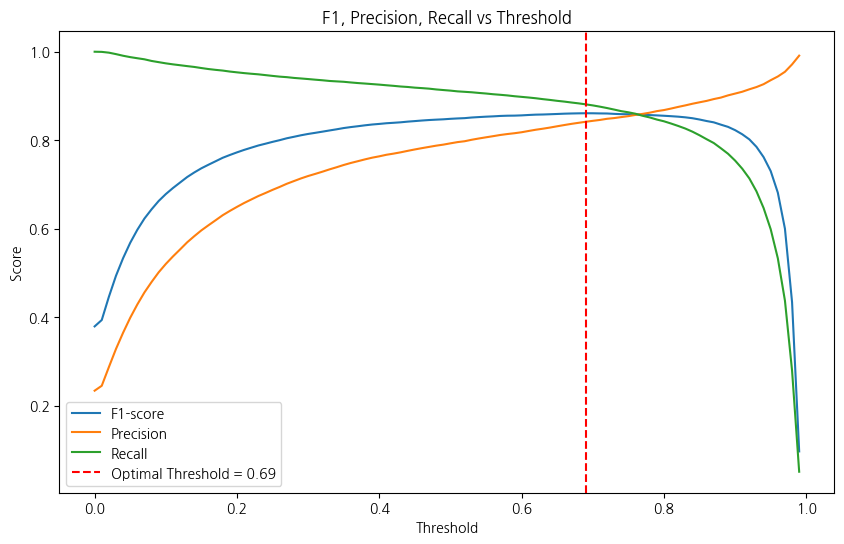

In [ ]:
# 임계값 찾기

# LightGBM 모델 학습
lgbm_model = LGBMClassifier(n_jobs=-1, n_estimators=2000, learning_rate = 0.01 ,scale_pos_weight=scale_pos_weight)
lgbm_model.fit(X_train, y_train)

# 예측 확률 계산
lgbm_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
f1_scores = []
precisions = []
recalls = []

# 각 임계값에서 성능 지표 계산
for threshold in thresholds:
    # 임계값에 따른 예측 결과 계산
    lgbm_test_pred_threshold = (lgbm_test_proba >= threshold).astype(int)

    # F1, Precision, Recall 계산
    f1 = f1_score(y_test, lgbm_test_pred_threshold)
    precision = precision_score(y_test, lgbm_test_pred_threshold)
    recall = recall_score(y_test, lgbm_test_pred_threshold)

    # 결과 저장
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# F1-score가 최대인 임계값 찾기
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"최적의 임계값: {optimal_threshold:.2f}")
print(f"최적 임계값에서의 F1-score: {f1_scores[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Precision: {precisions[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Recall: {recalls[optimal_idx]:.2f}")

# F1, Precision, Recall을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall vs Threshold')
plt.legend(loc='best')
plt.show()


Train Accuracy: 92.70%
Train f1_score: 85.44%
Train Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.93      0.95    258804
     Class 1       0.80      0.91      0.85     79073

    accuracy                           0.93    337877
   macro avg       0.89      0.92      0.90    337877
weighted avg       0.93      0.93      0.93    337877

Test Accuracy: 92.44%
Test f1_score: 84.92%
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.93      0.95     64702
     Class 1       0.80      0.91      0.85     19768

    accuracy                           0.92     84470
   macro avg       0.88      0.92      0.90     84470
weighted avg       0.93      0.92      0.93     84470

Train ROC AUC: 0.974
Test ROC AUC: 0.967


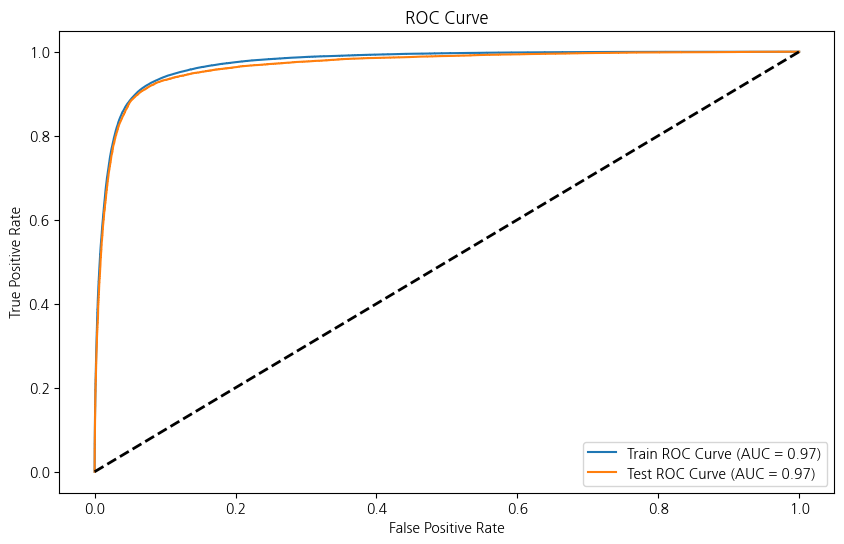

In [ ]:
# 임계값을 조정하여 예측하는 함수
def predict_with_threshold(model, X, threshold=0.5):
    probabilities = model.predict_proba(X)[:, 1]  # 클래스 1에 대한 확률
    return np.where(probabilities >= threshold, 1, 0)

# 임계값 설정 (여기서 원하는 값으로 조정 가능)
threshold = 0.69

# 학습 데이터에 대한 예측
lgbm_train_pred = predict_with_threshold(lgbm_model, X_train, threshold)

# 테스트 데이터에 대한 예측
lgbm_test_pred = predict_with_threshold(lgbm_model, X_test, threshold)

# 학습 데이터 성능 평가
lgbm_train_accuracy = accuracy_score(y_train, lgbm_train_pred)
lgbm_train_f1 = f1_score(y_train, lgbm_train_pred)
lgbm_train_report = classification_report(y_train, lgbm_train_pred, target_names=['Class 0', 'Class 1'])

print(f"Train Accuracy: {lgbm_train_accuracy * 100:.2f}%")
print(f"Train f1_score: {lgbm_train_f1 * 100:.2f}%")
print("Train Classification Report:")
print(lgbm_train_report)

# 테스트 데이터 성능 평가
lgbm_test_accuracy = accuracy_score(y_test, lgbm_test_pred)
lgbm_test_f1 = f1_score(y_test, lgbm_test_pred)
lgbm_test_report = classification_report(y_test, lgbm_test_pred, target_names=['Class 0', 'Class 1'])

print(f"Test Accuracy: {lgbm_test_accuracy * 100:.2f}%")
print(f"Test f1_score: {lgbm_test_f1 * 100:.2f}%")
print("Test Classification Report:")
print(lgbm_test_report)

# ROC AUC 계산
lgbm_train_auc = roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1])
lgbm_test_auc = roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:, 1])

print(f"Train ROC AUC: {lgbm_train_auc:.3f}")
print(f"Test ROC AUC: {lgbm_test_auc:.3f}")

# ROC Curve 시각화
fpr_train, tpr_train, _ = roc_curve(y_train, lgbm_model.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, lgbm_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {lgbm_train_auc:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {lgbm_test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Catboost

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.5889626	total: 31.7s	remaining: 31.7s
5001:	learn: 0.5889584	total: 31.7s	remaining: 31.7s
5002:	learn: 0.5889535	total: 31.7s	remaining: 31.7s
5003:	learn: 0.5889503	total: 31.7s	remaining: 31.7s
5004:	learn: 0.5889468	total: 31.7s	remaining: 31.6s
5005:	learn: 0.5889426	total: 31.7s	remaining: 31.6s
5006:	learn: 0.5889395	total: 31.7s	remaining: 31.6s
5007:	learn: 0.5889346	total: 31.7s	remaining: 31.6s
5008:	learn: 0.5889311	total: 31.7s	remaining: 31.6s
5009:	learn: 0.5889276	total: 31.7s	remaining: 31.6s
5010:	learn: 0.5889244	total: 31.8s	remaining: 31.6s
5011:	learn: 0.5889207	total: 31.8s	remaining: 31.6s
5012:	learn: 0.5889178	total: 31.8s	remaining: 31.6s
5013:	learn: 0.5889139	total: 31.8s	remaining: 31.6s
5014:	learn: 0.5889106	total: 31.8s	remaining: 31.6s
5015:	learn: 0.5889070	total: 31.8s	remaining: 31.6s
5016:	learn: 0.5889033	total: 31.8s	remaining: 31.6s
5017:	learn: 0.5889010	total: 31.8s	remaining: 31.6s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


최적의 임계값: 0.50
최적 임계값에서의 F1-score: 0.49
최적 임계값에서의 Precision: 0.38
최적 임계값에서의 Recall: 0.68


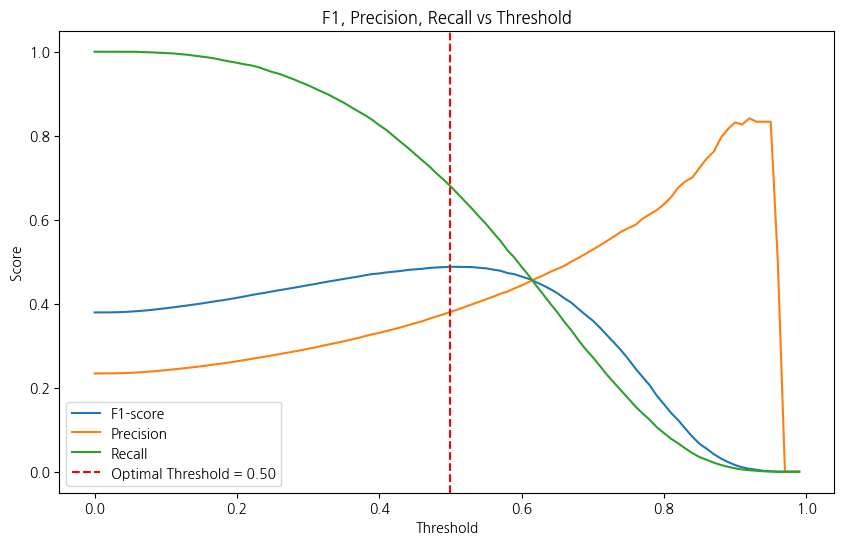

In [ ]:
# 임계값 찾기

cat_model = CatBoostClassifier(random_state=42, iterations=10000, learning_rate= 0.01, task_type="GPU", devices='0', bootstrap_type = 'Bayesian', auto_class_weights= 'Balanced')
cat_model.fit(X_train, y_train)

# 예측 확률 계산
cat_test_proba = cat_model.predict_proba(X_test)[:, 1]

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
f1_scores = []
precisions = []
recalls = []

# 각 임계값에서 성능 지표 계산
for threshold in thresholds:
    # 임계값에 따른 예측 결과 계산
    cat_test_pred_threshold = (cat_test_proba >= threshold).astype(int)

    # F1, Precision, Recall 계산
    f1 = f1_score(y_test, cat_test_pred_threshold)
    precision = precision_score(y_test, cat_test_pred_threshold)
    recall = recall_score(y_test, cat_test_pred_threshold)

    # 결과 저장
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# F1-score가 최대인 임계값 찾기
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"최적의 임계값: {optimal_threshold:.2f}")
print(f"최적 임계값에서의 F1-score: {f1_scores[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Precision: {precisions[optimal_idx]:.2f}")
print(f"최적 임계값에서의 Recall: {recalls[optimal_idx]:.2f}")

# F1, Precision, Recall을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall vs Threshold')
plt.legend(loc='best')
plt.show()


Train Accuracy: 68.46%
Train f1_score: 51.69%
Train Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.67      0.77    258804
     Class 1       0.40      0.72      0.52     79073

    accuracy                           0.68    337877
   macro avg       0.65      0.70      0.64    337877
weighted avg       0.77      0.68      0.71    337877

Test Accuracy: 66.62%
Test f1_score: 48.80%
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.66      0.75     64702
     Class 1       0.38      0.68      0.49     19768

    accuracy                           0.67     84470
   macro avg       0.63      0.67      0.62     84470
weighted avg       0.76      0.67      0.69     84470

Train ROC AUC: 0.769
Test ROC AUC: 0.735


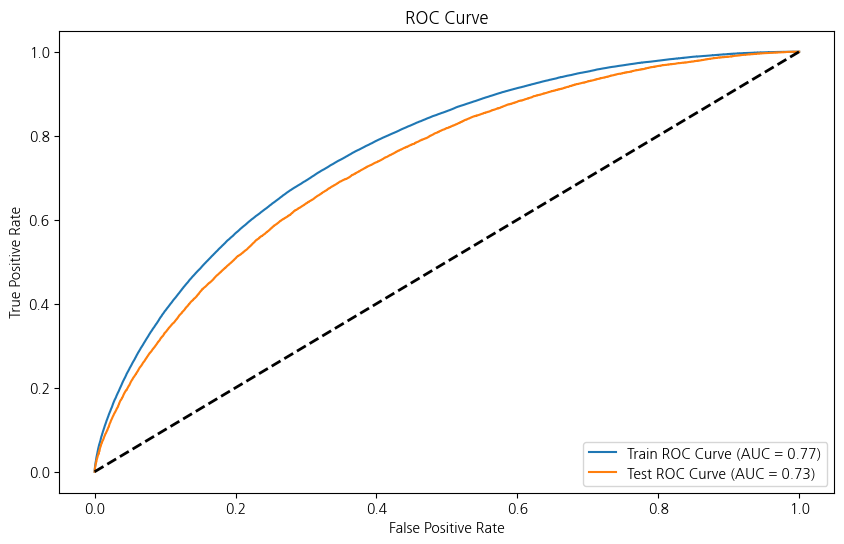

In [ ]:
# 임계값을 조정하여 예측하는 함수
def predict_with_threshold(model, X, threshold=0.5):
    probabilities = model.predict_proba(X)[:, 1]  # 클래스 1에 대한 확률
    return np.where(probabilities >= threshold, 1, 0)

# 임계값 설정 (여기서 원하는 값으로 조정 가능)
threshold = 0.5

# 학습 데이터에 대한 예측
cat_train_pred = predict_with_threshold(cat_model, X_train, threshold)

# 테스트 데이터에 대한 예측
cat_test_pred = predict_with_threshold(cat_model, X_test, threshold)

# 학습 데이터 성능 평가
cat_train_accuracy = accuracy_score(y_train, cat_train_pred)
cat_train_f1 = f1_score(y_train, cat_train_pred)
cat_train_report = classification_report(y_train, cat_train_pred, target_names=['Class 0', 'Class 1'])

print(f"Train Accuracy: {cat_train_accuracy * 100:.2f}%")
print(f"Train f1_score: {cat_train_f1 * 100:.2f}%")
print("Train Classification Report:")
print(cat_train_report)

# 테스트 데이터 성능 평가
cat_test_accuracy = accuracy_score(y_test, cat_test_pred)
cat_test_f1 = f1_score(y_test, cat_test_pred)
cat_test_report = classification_report(y_test, cat_test_pred, target_names=['Class 0', 'Class 1'])

print(f"Test Accuracy: {cat_test_accuracy * 100:.2f}%")
print(f"Test f1_score: {cat_test_f1 * 100:.2f}%")
print("Test Classification Report:")
print(cat_test_report)

# ROC AUC 계산
cat_train_auc = roc_auc_score(y_train, cat_model.predict_proba(X_train)[:, 1])
cat_test_auc = roc_auc_score(y_test, cat_model.predict_proba(X_test)[:, 1])

print(f"Train ROC AUC: {cat_train_auc:.3f}")
print(f"Test ROC AUC: {cat_test_auc:.3f}")

# ROC Curve 시각화
fpr_train, tpr_train, _ = roc_curve(y_train, cat_model.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, cat_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {cat_train_auc:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {cat_test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
features = df_X.columns
# lgbm의 feature importance와 그에 따른 순위 부여
cat_importance = pd.DataFrame({
    'Feature': features,
    'cat_importance': cat_model.feature_importances_
})

# 같은 점수에 같은 등급 부여 후 정수형으로 변환
cat_importance.sort_values(by='cat_importance', ascending=False, inplace=True)
cat_importance['cat_rank'] = cat_importance['cat_importance'].rank(method='min', ascending=False).astype(int)

result_cat = cat_importance[['Feature', 'cat_importance', 'cat_rank']].reset_index(drop = True)
result_cat

Feature  cat_importance  cat_rank
0                 이자율           18.13         1
1               대출 금액           11.49         2
2          총 신용/대출 한도            6.55         3
3               연간 소득            5.50         4
4                 DTI            5.49         5
5         총 리볼빙 잔여 한도            5.47         6
6   가장 오래된 회전 계좌 개월 수            5.23         7
7   가장 오래된 할부 계좌 개월 수            4.56         8
8             Fico 등급            4.47         9
9            신용한도 사용률            4.30        10
10              근속 연수            4.14        11
11           리볼빙 계좌 수            3.63        12
12           모기지 계좌 수            3.29        13
13          대출 기간 (연)            3.24        14
14              대출 목적            2.88        15
15        개설된 회전 계좌 수            2.33        16
16    12개월 내 개설된 계좌 수            2.30        17
17           주택 소유 상태            2.09        18
18                 주소            2.08        19
19            고한도 사용률            1.61        20
20           소득 확인 상태            1.23        21

## shap

In [ ]:
# rf
rf_explainer = shap.TreeExplainer(rf_model)

rf_shap_values = rf_explainer.shap_values(X_train)

rf_shap_values_class_1 = rf_shap_values[1]

In [ ]:
shap.summary_plot(rf_shap_values, X_train)

In [ ]:
# xgbc
xgbc_explainer = shap.TreeExplainer(xgb_model)

xgbc_shap_values = xgbc_explainer.shap_values(X_train)

xgbc_shap_values_class_1 = xgbc_shap_values[1]

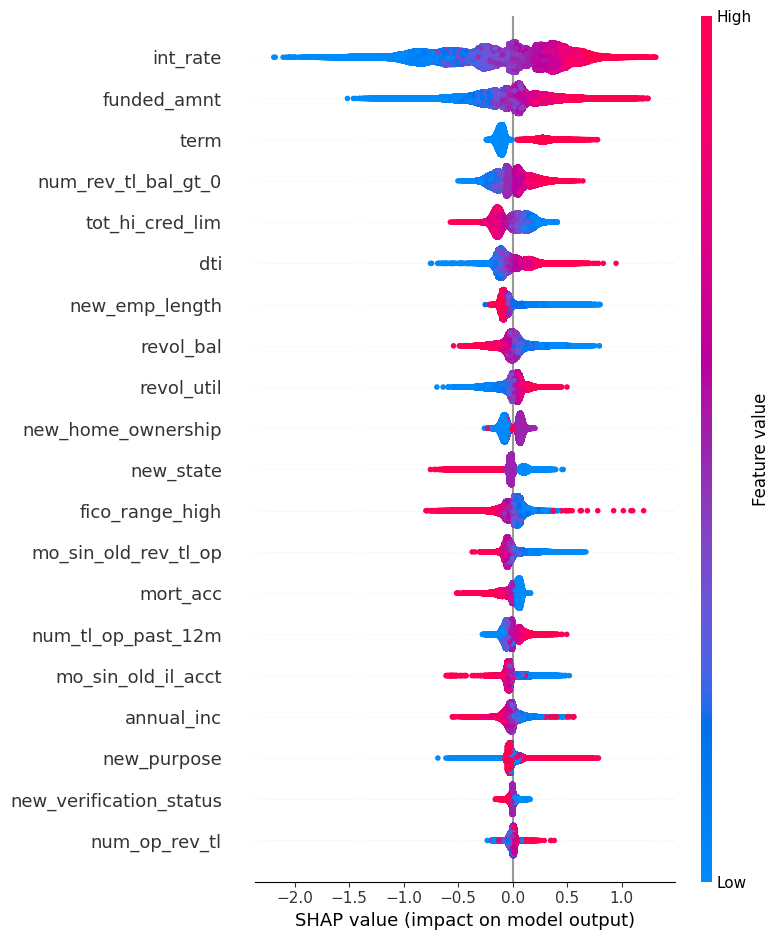

In [ ]:
shap.summary_plot(xgbc_shap_values, X_train)

In [ ]:
# lgbm
lgbm_explainer = shap.TreeExplainer(lgbm_model)

lgbm_shap_values = lgbm_explainer.shap_values(X_train)

lgbm_shap_values_class_1 = lgbm_shap_values[1]

In [ ]:
shap.summary_plot(lgbm_shap_values, X_train)

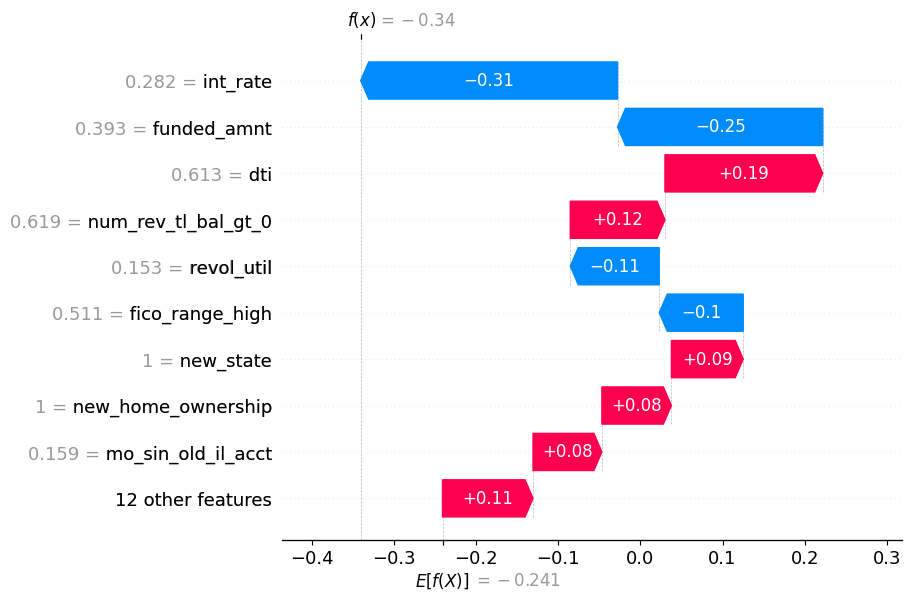

In [ ]:
import shap
import matplotlib.pyplot as plt

# # lgb_model이 훈련된 LightGBM 모델이고 X_train이 학습 데이터라고 가정합니다.
# lgbm_explainer = shap.TreeExplainer(lgb_model)

# # 학습 데이터에 대한 SHAP 값을 계산합니다.
# lgbm_shap_values = lgbm_explainer.lgbm_shap_values(X_train)

# 설명할 관측치의 인덱스를 선택합니다.
index_to_explain = 2  # 설명할 관측치의 인덱스를 변경할 수 있습니다.

# SHAP 값과 expected_value(예상값)를 올바르게 처리합니다.
# 이진 분류의 경우 lgbm_shap_values는 배열의 리스트일 수 있습니다.
if isinstance(lgbm_shap_values, list):
    lgbm_shap_values_for_plot = lgbm_shap_values[1]  # 양성 클래스에 대한 SHAP 값을 사용합니다.
else:
    lgbm_shap_values_for_plot = lgbm_shap_values

# 선택된 관측치에 대한 SHAP waterfall 플롯을 생성합니다.
shap.waterfall_plot(shap.Explanation(values=lgbm_shap_values_for_plot[index_to_explain],
                                     base_values=lgbm_explainer.expected_value,
                                     data=X_train.iloc[index_to_explain],
                                     feature_names=X_train.columns))

# 화면에 플롯을 표시합니다.
plt.show()


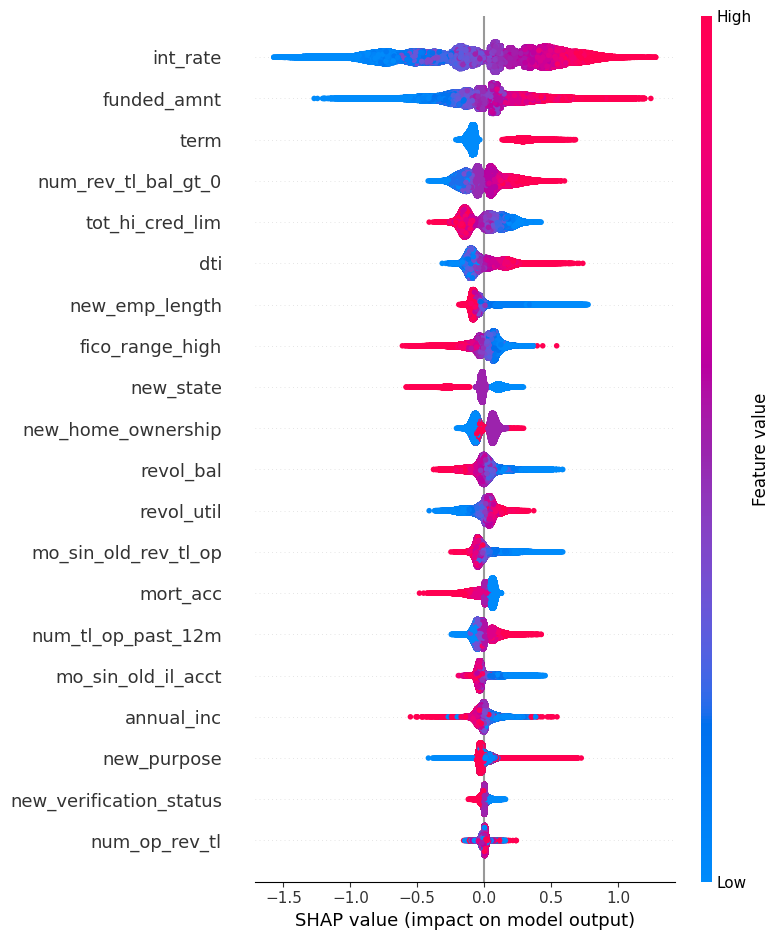

In [ ]:
shap.summary_plot(lgbm_shap_values, X_train)

In [ ]:
# cat
cat_explainer = shap.TreeExplainer(cat_model)

cat_shap_values = cat_explainer.shap_values(X_train)

cat_shap_values_class_1 = cat_shap_values[1]

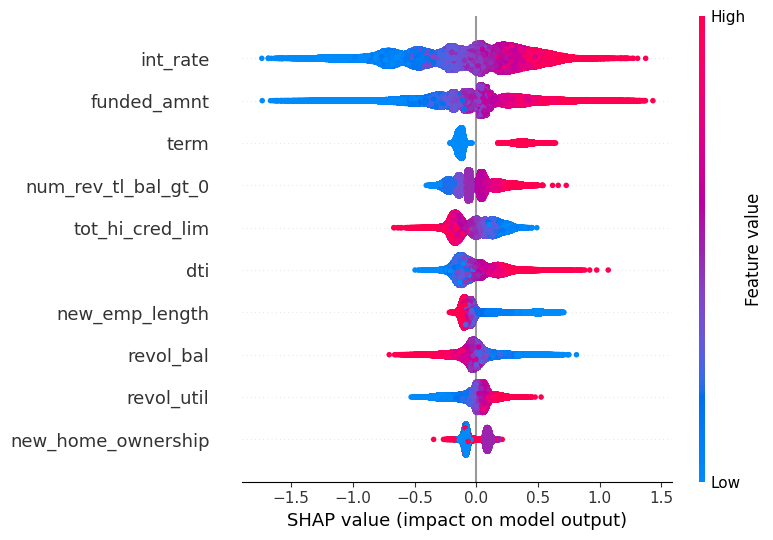

In [ ]:
shap.summary_plot(cat_shap_values, X_train, max_display=10)

# kfold

## rf

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

평균 최적 임계값: 0.262
평균 최적 임계값에서의 F1-score: 0.478
평균 최적 임계값에서의 Precision: 0.374
평균 최적 임계값에서의 Recall: 0.664
평균 최적 임계값에서의 AUC: 0.722


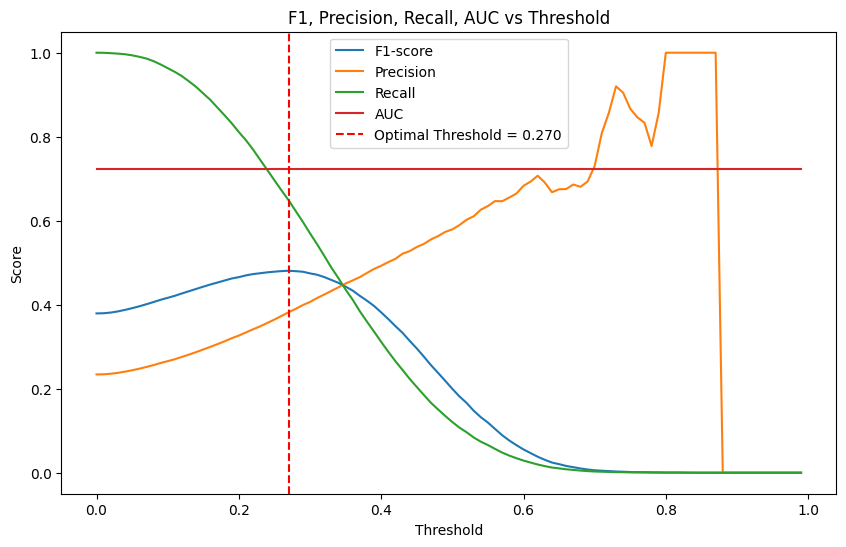

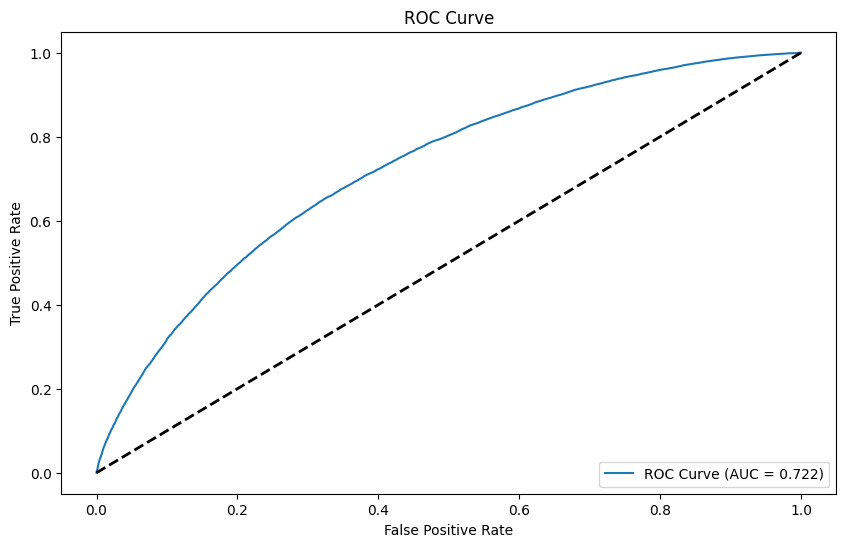

In [ ]:
# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 Stratified K-Fold 교차 검증 수행
# for train_index, test_index in kf.split(X_train):
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Random Forest 모델 학습
    rf_model = RandomForestClassifier(n_estimators=2000, random_state=42)
    rf_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    rf_test_proba = rf_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        rf_test_pred_threshold = (rf_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, rf_test_pred_threshold)
        precision = precision_score(y_test_fold, rf_test_pred_threshold)
        recall = recall_score(y_test_fold, rf_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, rf_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, rf_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## xgbc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

평균 최적 임계값: 0.512
평균 최적 임계값에서의 F1-score: 0.486
평균 최적 임계값에서의 Precision: 0.386
평균 최적 임계값에서의 Recall: 0.657
평균 최적 임계값에서의 AUC: 0.731


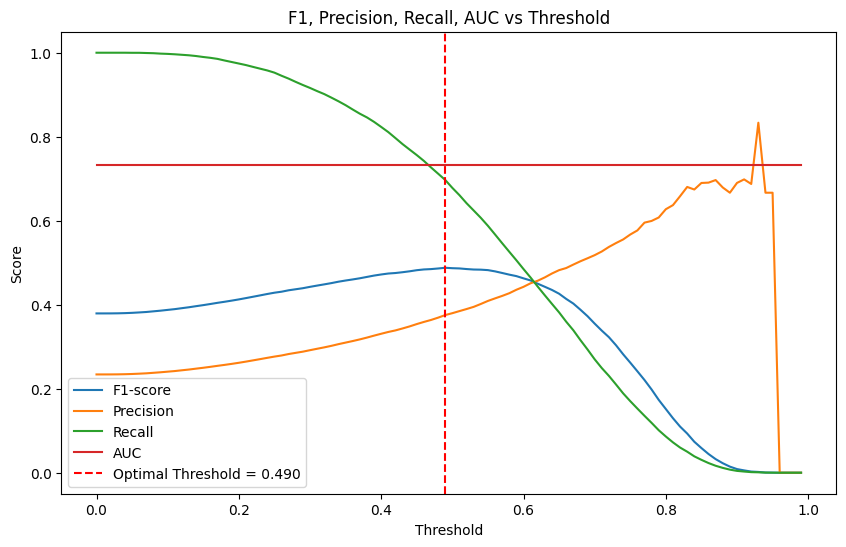

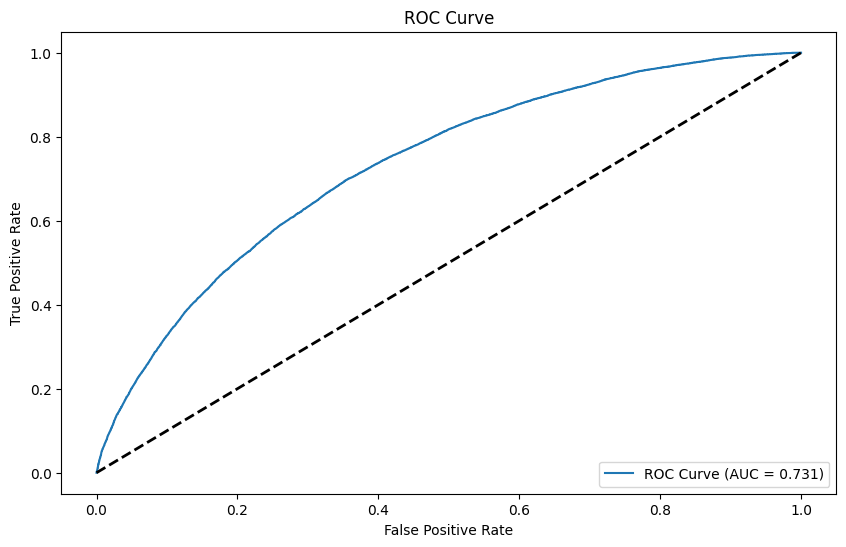

In [ ]:
# K-fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 교차 검증 수행
# for train_index, test_index in kf.split(X_train):
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # XGBoost 모델 학습
    xgb_model = XGBClassifier(n_jobs=-1, n_estimators=2000, learning_rate=0.01, scale_pos_weight=scale_pos_weight)
    xgb_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    xgb_test_proba = xgb_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        xgb_test_pred_threshold = (xgb_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, xgb_test_pred_threshold)
        precision = precision_score(y_test_fold, xgb_test_pred_threshold)
        recall = recall_score(y_test_fold, xgb_test_pred_threshold)
        # auc = roc_auc_score(y_test_fold, xgb_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, xgb_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, xgb_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## lgbc

[LightGBM] [Info] Number of positive: 63258, number of negative: 207043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270301, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234028 -> initscore=-1.185705
[LightGBM] [Info] Start training from score -1.185705


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63258, number of negative: 207043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270301, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234028 -> initscore=-1.185705
[LightGBM] [Info] Start training from score -1.185705


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63259, number of negative: 207043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270302, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234031 -> initscore=-1.185689
[LightGBM] [Info] Start training from score -1.185689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63259, number of negative: 207043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270302, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234031 -> initscore=-1.185689
[LightGBM] [Info] Start training from score -1.185689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63258, number of negative: 207044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2412
[LightGBM] [Info] Number of data points in the train set: 270302, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234027 -> initscore=-1.185710
[LightGBM] [Info] Start training from score -1.185710


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

평균 최적 임계값: 0.512
평균 최적 임계값에서의 F1-score: 0.485
평균 최적 임계값에서의 Precision: 0.382
평균 최적 임계값에서의 Recall: 0.664
평균 최적 임계값에서의 AUC: 0.731


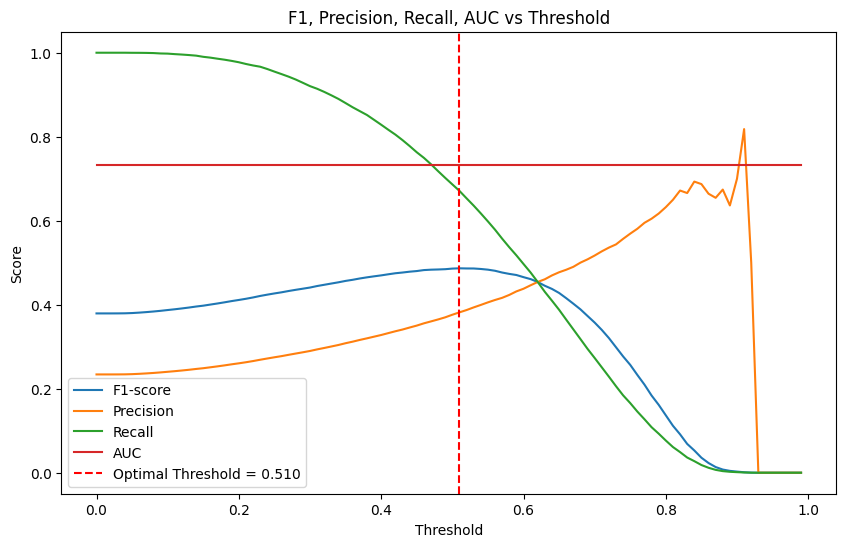

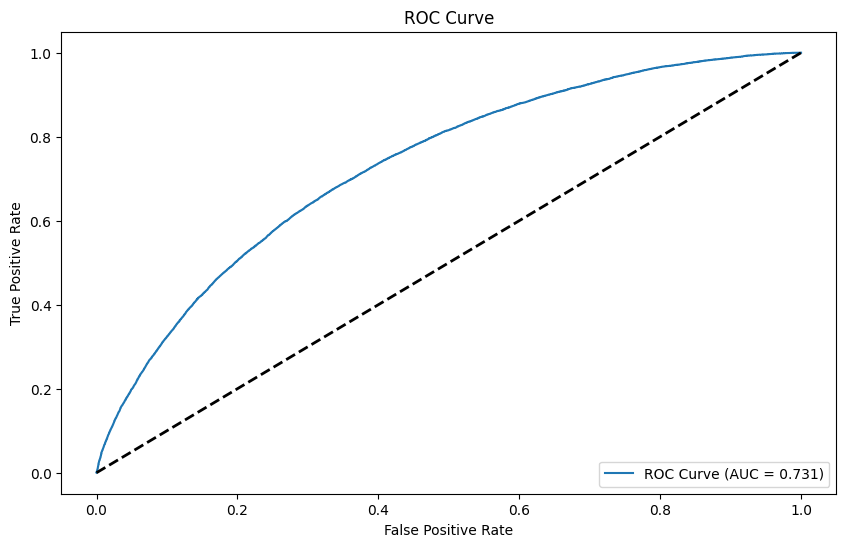

In [ ]:
# K-fold 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 교차 검증 수행
# for train_index, test_index in kf.split(X_train):
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # LGBM 모델 학습
    lgbm_model = LGBMClassifier(n_jobs=-1, n_estimators=2000, learning_rate=0.01, scale_pos_weight=scale_pos_weight)
    lgbm_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    lgbm_test_proba = lgbm_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        lgbm_test_pred_threshold = (lgbm_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, lgbm_test_pred_threshold)
        precision = precision_score(y_test_fold, lgbm_test_pred_threshold)
        recall = recall_score(y_test_fold, lgbm_test_pred_threshold)
        # auc = roc_auc_score(y_test_fold, lgbm_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, lgbm_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, lgbm_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## catboost

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.5851122	total: 27.5s	remaining: 27.5s
5001:	learn: 0.5851083	total: 27.5s	remaining: 27.5s
5002:	learn: 0.5851043	total: 27.5s	remaining: 27.5s
5003:	learn: 0.5851011	total: 27.5s	remaining: 27.5s
5004:	learn: 0.5850967	total: 27.5s	remaining: 27.5s
5005:	learn: 0.5850923	total: 27.5s	remaining: 27.5s
5006:	learn: 0.5850880	total: 27.5s	remaining: 27.5s
5007:	learn: 0.5850848	total: 27.5s	remaining: 27.4s
5008:	learn: 0.5850800	total: 27.5s	remaining: 27.4s
5009:	learn: 0.5850767	total: 27.5s	remaining: 27.4s
5010:	learn: 0.5850743	total: 27.6s	remaining: 27.4s
5011:	learn: 0.5850706	total: 27.6s	remaining: 27.4s
5012:	learn: 0.5850659	total: 27.6s	remaining: 27.4s
5013:	learn: 0.5850619	total: 27.6s	remaining: 27.4s
5014:	learn: 0.5850577	total: 27.6s	remaining: 27.4s
5015:	learn: 0.5850539	total: 27.6s	remaining: 27.4s
5016:	learn: 0.5850500	total: 27.6s	remaining: 27.4s
5017:	learn: 0.5850456	total: 27.6s	remaining: 27.4s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.5861719	total: 27.7s	remaining: 27.7s
5001:	learn: 0.5861670	total: 27.7s	remaining: 27.7s
5002:	learn: 0.5861642	total: 27.7s	remaining: 27.7s
5003:	learn: 0.5861601	total: 27.7s	remaining: 27.7s
5004:	learn: 0.5861567	total: 27.7s	remaining: 27.7s
5005:	learn: 0.5861523	total: 27.7s	remaining: 27.7s
5006:	learn: 0.5861481	total: 27.8s	remaining: 27.7s
5007:	learn: 0.5861437	total: 27.8s	remaining: 27.7s
5008:	learn: 0.5861394	total: 27.8s	remaining: 27.7s
5009:	learn: 0.5861349	total: 27.8s	remaining: 27.7s
5010:	learn: 0.5861303	total: 27.8s	remaining: 27.6s
5011:	learn: 0.5861245	total: 27.8s	remaining: 27.6s
5012:	learn: 0.5861208	total: 27.8s	remaining: 27.6s
5013:	learn: 0.5861176	total: 27.8s	remaining: 27.6s
5014:	learn: 0.5861142	total: 27.8s	remaining: 27.6s
5015:	learn: 0.5861100	total: 27.8s	remaining: 27.6s
5016:	learn: 0.5861048	total: 27.8s	remaining: 27.6s
5017:	learn: 0.5860994	total: 27.8s	remaining: 27.6s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.5864116	total: 27s	remaining: 27s
5001:	learn: 0.5864089	total: 27s	remaining: 27s
5002:	learn: 0.5864054	total: 27s	remaining: 27s
5003:	learn: 0.5864021	total: 27s	remaining: 27s
5004:	learn: 0.5863989	total: 27s	remaining: 27s
5005:	learn: 0.5863954	total: 27s	remaining: 27s
5006:	learn: 0.5863919	total: 27s	remaining: 27s
5007:	learn: 0.5863881	total: 27.1s	remaining: 27s
5008:	learn: 0.5863838	total: 27.1s	remaining: 27s
5009:	learn: 0.5863792	total: 27.1s	remaining: 27s
5010:	learn: 0.5863733	total: 27.1s	remaining: 27s
5011:	learn: 0.5863709	total: 27.1s	remaining: 26.9s
5012:	learn: 0.5863672	total: 27.1s	remaining: 26.9s
5013:	learn: 0.5863636	total: 27.1s	remaining: 26.9s
5014:	learn: 0.5863602	total: 27.1s	remaining: 26.9s
5015:	learn: 0.5863564	total: 27.1s	remaining: 26.9s
5016:	learn: 0.5863517	total: 27.1s	remaining: 26.9s
5017:	learn: 0.5863479	total: 27.1s	remaining: 26.9s
5018:	learn: 0.5863440	total: 27.1s	remaining:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.5858666	total: 27s	remaining: 27s
5001:	learn: 0.5858619	total: 27s	remaining: 27s
5002:	learn: 0.5858578	total: 27s	remaining: 27s
5003:	learn: 0.5858546	total: 27s	remaining: 27s
5004:	learn: 0.5858504	total: 27s	remaining: 27s
5005:	learn: 0.5858469	total: 27s	remaining: 26.9s
5006:	learn: 0.5858433	total: 27s	remaining: 26.9s
5007:	learn: 0.5858399	total: 27s	remaining: 26.9s
5008:	learn: 0.5858359	total: 27s	remaining: 26.9s
5009:	learn: 0.5858298	total: 27s	remaining: 26.9s
5010:	learn: 0.5858252	total: 27s	remaining: 26.9s
5011:	learn: 0.5858200	total: 27s	remaining: 26.9s
5012:	learn: 0.5858155	total: 27s	remaining: 26.9s
5013:	learn: 0.5858121	total: 27.1s	remaining: 26.9s
5014:	learn: 0.5858084	total: 27.1s	remaining: 26.9s
5015:	learn: 0.5858039	total: 27.1s	remaining: 26.9s
5016:	learn: 0.5858002	total: 27.1s	remaining: 26.9s
5017:	learn: 0.5857971	total: 27.1s	remaining: 26.9s
5018:	learn: 0.5857937	total: 27.1s	remaining:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.5851542	total: 26.8s	remaining: 26.8s
5001:	learn: 0.5851498	total: 26.8s	remaining: 26.8s
5002:	learn: 0.5851463	total: 26.8s	remaining: 26.8s
5003:	learn: 0.5851420	total: 26.8s	remaining: 26.8s
5004:	learn: 0.5851389	total: 26.8s	remaining: 26.8s
5005:	learn: 0.5851359	total: 26.8s	remaining: 26.8s
5006:	learn: 0.5851331	total: 26.8s	remaining: 26.8s
5007:	learn: 0.5851296	total: 26.8s	remaining: 26.8s
5008:	learn: 0.5851257	total: 26.8s	remaining: 26.7s
5009:	learn: 0.5851215	total: 26.8s	remaining: 26.7s
5010:	learn: 0.5851175	total: 26.9s	remaining: 26.7s
5011:	learn: 0.5851145	total: 26.9s	remaining: 26.7s
5012:	learn: 0.5851114	total: 26.9s	remaining: 26.7s
5013:	learn: 0.5851082	total: 26.9s	remaining: 26.7s
5014:	learn: 0.5851039	total: 26.9s	remaining: 26.7s
5015:	learn: 0.5850999	total: 26.9s	remaining: 26.7s
5016:	learn: 0.5850949	total: 26.9s	remaining: 26.7s
5017:	learn: 0.5850907	total: 26.9s	remaining: 26.7s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


평균 최적 임계값: 0.506
평균 최적 임계값에서의 F1-score: 0.487
평균 최적 임계값에서의 Precision: 0.384
평균 최적 임계값에서의 Recall: 0.666
평균 최적 임계값에서의 AUC: 0.733


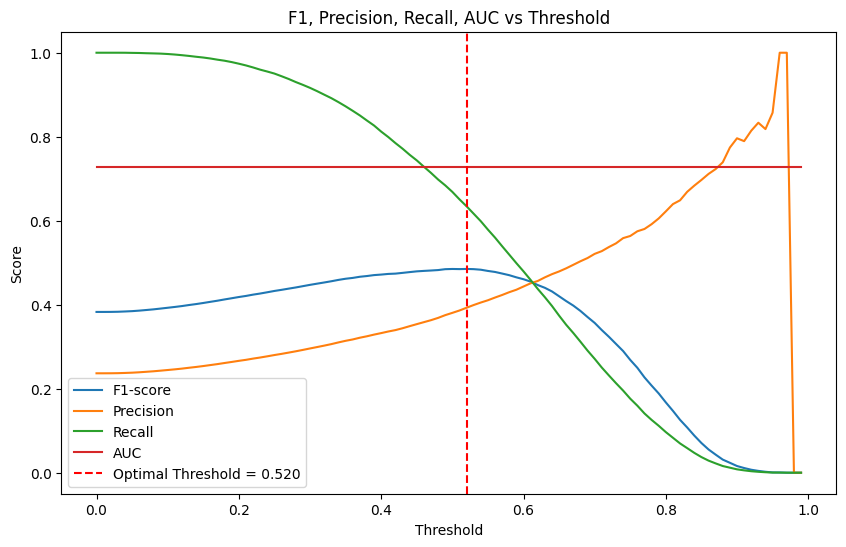

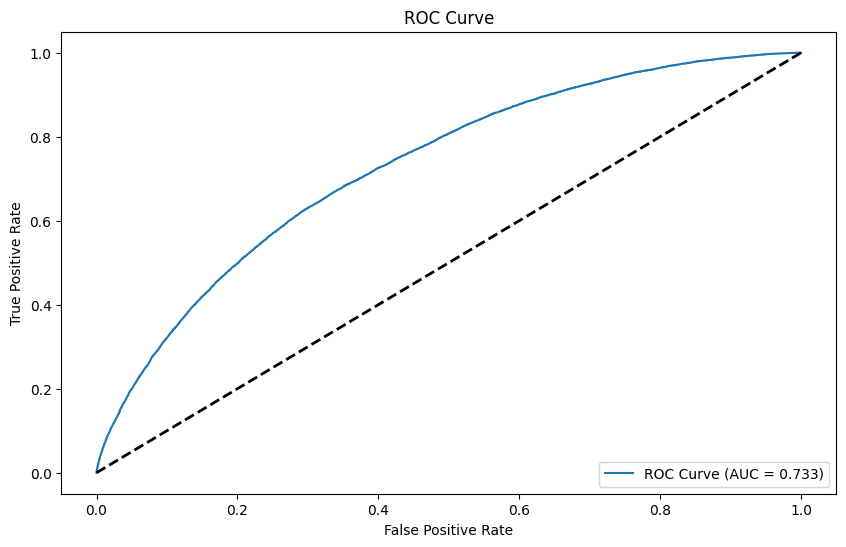

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# K-fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 교차 검증 수행
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # CatBoost 모델 학습
    cat_model = cat_model = CatBoostClassifier(random_state=42, iterations=10000, learning_rate= 0.01, task_type="GPU", devices='0', bootstrap_type = 'Bayesian', auto_class_weights= 'Balanced')
    cat_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    cat_test_proba = cat_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        cat_test_pred_threshold = (cat_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, cat_test_pred_threshold)
        precision = precision_score(y_test_fold, cat_test_pred_threshold)
        recall = recall_score(y_test_fold, cat_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, cat_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, cat_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# ENN

In [ ]:
# 피쳐, 타겟 분리
df_X = df_1.drop(columns='loan_status_N')
df_y = df_1['loan_status_N']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=1234, stratify=df_y)

print(df_X.shape, df_y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)

X_train_enn.to_feather('/content/drive/MyDrive/Data/이찬/X_train_ENN_0823.feather')
y_train_enn.to_csv('/content/drive/MyDrive/Data/이찬/y_train_ENN_0823.csv',index = False)
X_test.to_feather('/content/drive/MyDrive/Data/이찬/X_test_ENN_0823.feather')
y_test.to_csv('/content/drive/MyDrive/Data/이찬/y_test_ENN_0823.csv',index = False)

X_train = pd.read_feather('/content/drive/MyDrive/Data/이찬/X_train_ENN_0823.feather')
y_train = pd.read_csv('/content/drive/MyDrive/Data/이찬/y_train_ENN_0823.csv')
X_test = pd.read_feather('/content/drive/MyDrive/Data/이찬/X_test_ENN_0823.feather')
y_test = pd.read_csv('/content/drive/MyDrive/Data/이찬/y_test_ENN_0823.csv')

(422347, 21) (422347,) (337877, 21) (84470, 21) (337877,) (84470,)


In [ ]:
X_train = pd.read_feather('/content/drive/MyDrive/Data/이찬/X_train_ENN_0823.feather')
y_train = pd.read_csv('/content/drive/MyDrive/Data/이찬/y_train_ENN_0823.csv')
X_test = pd.read_feather('/content/drive/MyDrive/Data/이찬/X_test_ENN_0823.feather')
y_test = pd.read_csv('/content/drive/MyDrive/Data/이찬/y_test_ENN_0823.csv')

print(df_X.shape, df_y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(422347, 21) (422347,) (337877, 21) (84470, 21) (337877, 1) (84470, 1)


In [ ]:
y_train.value_counts()

loan_status_N
0                258804
1                 79073
Name: count, dtype: int64

## rf

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

평균 최적 임계값: 0.262
평균 최적 임계값에서의 F1-score: 0.478
평균 최적 임계값에서의 Precision: 0.374
평균 최적 임계값에서의 Recall: 0.664
평균 최적 임계값에서의 AUC: 0.722


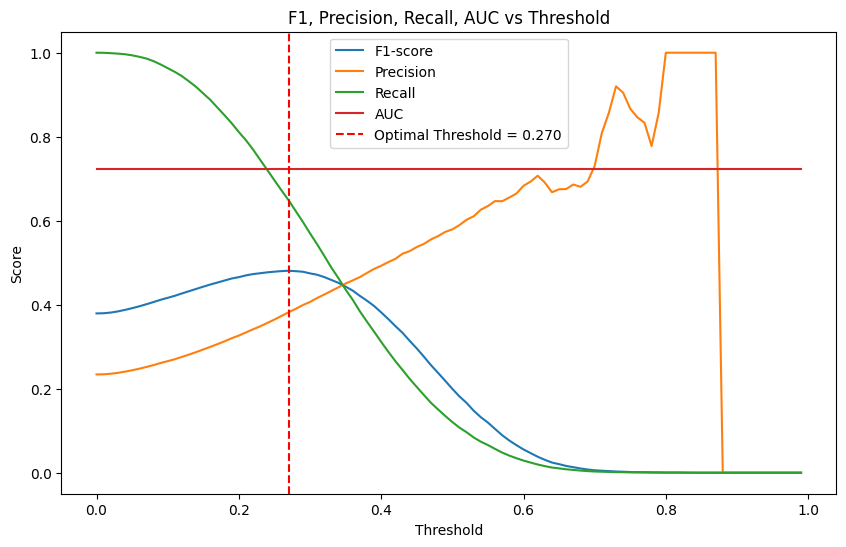

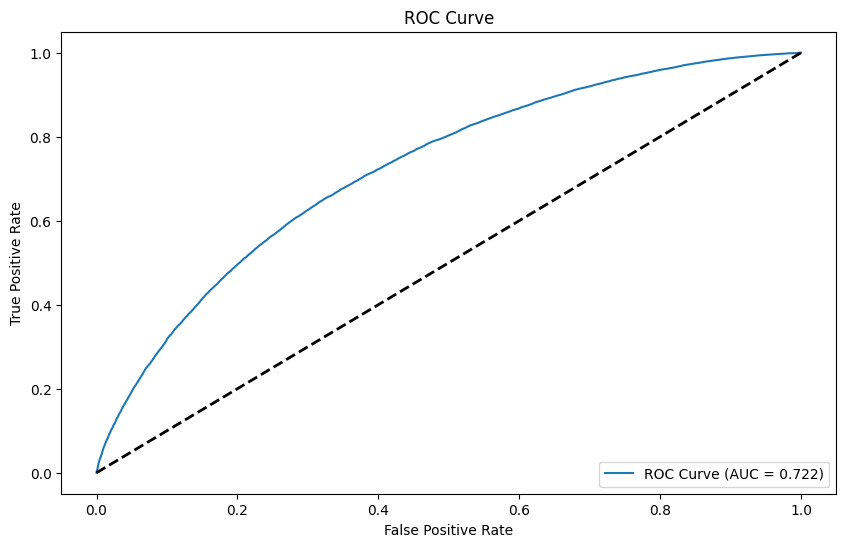

In [ ]:
# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 Stratified K-Fold 교차 검증 수행
# for train_index, test_index in kf.split(X_train):
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Random Forest 모델 학습
    rf_model = RandomForestClassifier(n_estimators=2000, random_state=42)
    rf_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    rf_test_proba = rf_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        rf_test_pred_threshold = (rf_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, rf_test_pred_threshold)
        precision = precision_score(y_test_fold, rf_test_pred_threshold)
        recall = recall_score(y_test_fold, rf_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, rf_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, rf_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## xgbc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

평균 최적 임계값: 0.248
평균 최적 임계값에서의 F1-score: 0.486
평균 최적 임계값에서의 Precision: 0.386
평균 최적 임계값에서의 Recall: 0.657
평균 최적 임계값에서의 AUC: 0.731


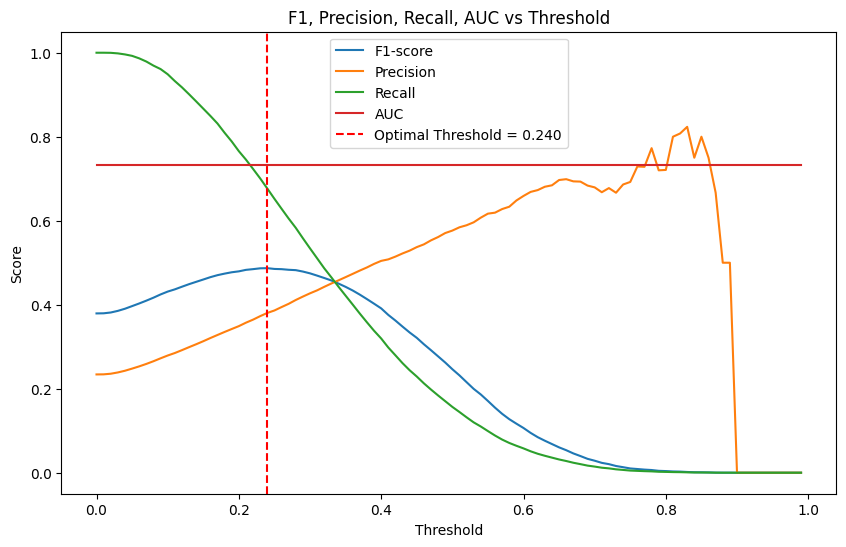

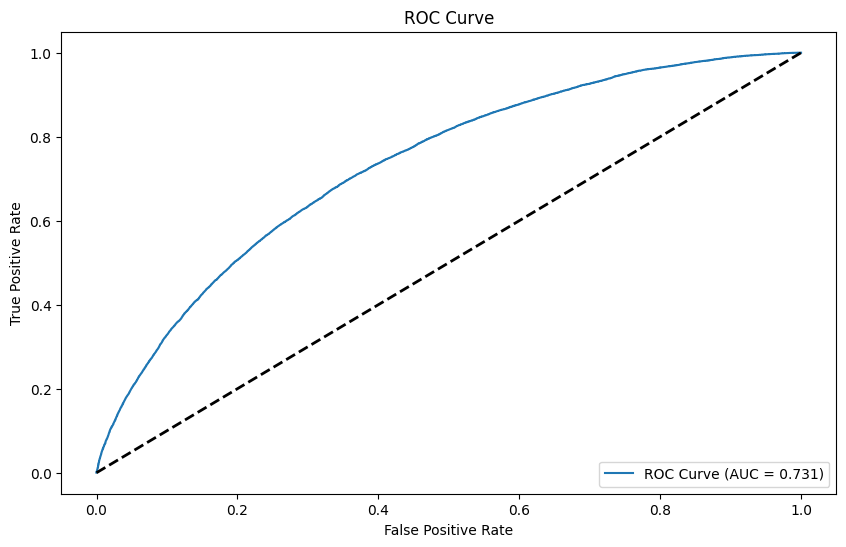

In [ ]:
# K-fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 교차 검증 수행
# for train_index, test_index in kf.split(X_train):
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # XGBoost 모델 학습
    xgb_model = XGBClassifier(n_jobs=-1, n_estimators=2000, learning_rate=0.01)
    xgb_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    xgb_test_proba = xgb_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        xgb_test_pred_threshold = (xgb_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, xgb_test_pred_threshold)
        precision = precision_score(y_test_fold, xgb_test_pred_threshold)
        recall = recall_score(y_test_fold, xgb_test_pred_threshold)
        # auc = roc_auc_score(y_test_fold, xgb_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, xgb_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, xgb_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## lgbc

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 63258, number of negative: 207043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270301, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234028 -> initscore=-1.185705
[LightGBM] [Info] Start training from score -1.185705


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63258, number of negative: 207043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270301, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234028 -> initscore=-1.185705
[LightGBM] [Info] Start training from score -1.185705


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63259, number of negative: 207043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270302, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234031 -> initscore=-1.185689
[LightGBM] [Info] Start training from score -1.185689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63259, number of negative: 207043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 270302, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234031 -> initscore=-1.185689
[LightGBM] [Info] Start training from score -1.185689


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

[LightGBM] [Info] Number of positive: 63258, number of negative: 207044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2412
[LightGBM] [Info] Number of data points in the train set: 270302, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234027 -> initscore=-1.185710
[LightGBM] [Info] Start training from score -1.185710


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

평균 최적 임계값: 0.238
평균 최적 임계값에서의 F1-score: 0.485
평균 최적 임계값에서의 Precision: 0.378
평균 최적 임계값에서의 Recall: 0.679
평균 최적 임계값에서의 AUC: 0.731


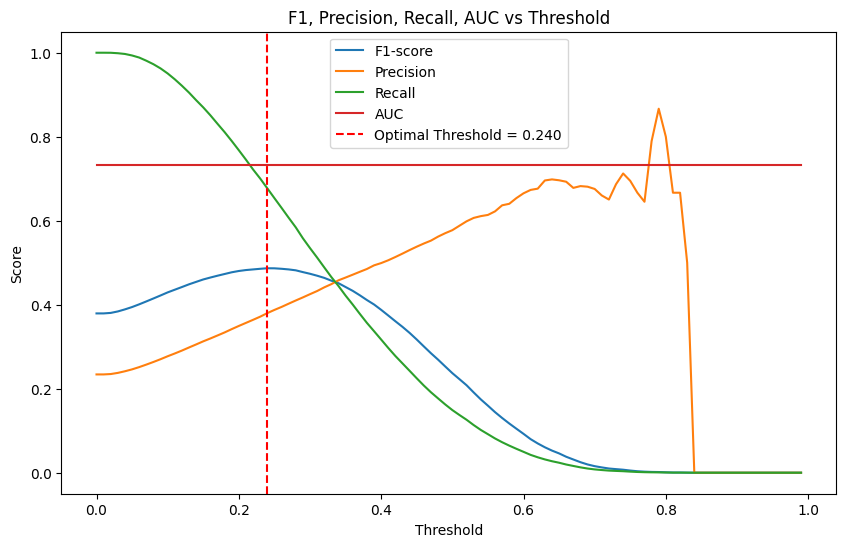

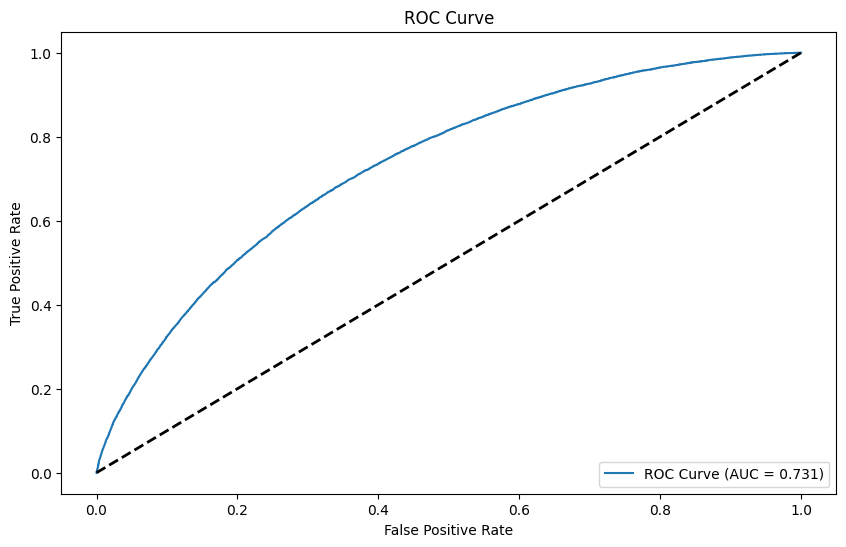

In [ ]:
# K-fold 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 교차 검증 수행
# for train_index, test_index in kf.split(X_train):
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # LGBM 모델 학습
    lgbm_model = LGBMClassifier(n_jobs=-1, n_estimators=2000, learning_rate=0.01)
    lgbm_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    lgbm_test_proba = lgbm_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        lgbm_test_pred_threshold = (lgbm_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, lgbm_test_pred_threshold)
        precision = precision_score(y_test_fold, lgbm_test_pred_threshold)
        recall = recall_score(y_test_fold, lgbm_test_pred_threshold)
        # auc = roc_auc_score(y_test_fold, lgbm_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, lgbm_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, lgbm_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## catboost

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.4671283	total: 27.6s	remaining: 27.6s
5001:	learn: 0.4671250	total: 27.6s	remaining: 27.6s
5002:	learn: 0.4671235	total: 27.6s	remaining: 27.6s
5003:	learn: 0.4671205	total: 27.6s	remaining: 27.6s
5004:	learn: 0.4671173	total: 27.6s	remaining: 27.6s
5005:	learn: 0.4671145	total: 27.6s	remaining: 27.6s
5006:	learn: 0.4671123	total: 27.6s	remaining: 27.6s
5007:	learn: 0.4671093	total: 27.6s	remaining: 27.6s
5008:	learn: 0.4671062	total: 27.6s	remaining: 27.5s
5009:	learn: 0.4671033	total: 27.7s	remaining: 27.5s
5010:	learn: 0.4671002	total: 27.7s	remaining: 27.5s
5011:	learn: 0.4670978	total: 27.7s	remaining: 27.5s
5012:	learn: 0.4670952	total: 27.7s	remaining: 27.5s
5013:	learn: 0.4670920	total: 27.7s	remaining: 27.5s
5014:	learn: 0.4670899	total: 27.7s	remaining: 27.5s
5015:	learn: 0.4670878	total: 27.7s	remaining: 27.5s
5016:	learn: 0.4670853	total: 27.7s	remaining: 27.5s
5017:	learn: 0.4670832	total: 27.7s	remaining: 27.5s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.4683691	total: 27.3s	remaining: 27.3s
5001:	learn: 0.4683656	total: 27.3s	remaining: 27.3s
5002:	learn: 0.4683631	total: 27.3s	remaining: 27.3s
5003:	learn: 0.4683604	total: 27.4s	remaining: 27.3s
5004:	learn: 0.4683579	total: 27.4s	remaining: 27.3s
5005:	learn: 0.4683549	total: 27.4s	remaining: 27.3s
5006:	learn: 0.4683519	total: 27.4s	remaining: 27.3s
5007:	learn: 0.4683492	total: 27.4s	remaining: 27.3s
5008:	learn: 0.4683474	total: 27.4s	remaining: 27.3s
5009:	learn: 0.4683449	total: 27.4s	remaining: 27.3s
5010:	learn: 0.4683419	total: 27.4s	remaining: 27.3s
5011:	learn: 0.4683384	total: 27.4s	remaining: 27.3s
5012:	learn: 0.4683364	total: 27.4s	remaining: 27.3s
5013:	learn: 0.4683332	total: 27.4s	remaining: 27.3s
5014:	learn: 0.4683317	total: 27.4s	remaining: 27.2s
5015:	learn: 0.4683295	total: 27.4s	remaining: 27.2s
5016:	learn: 0.4683270	total: 27.4s	remaining: 27.2s
5017:	learn: 0.4683244	total: 27.4s	remaining: 27.2s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.4684091	total: 27.5s	remaining: 27.5s
5001:	learn: 0.4684061	total: 27.5s	remaining: 27.5s
5002:	learn: 0.4684044	total: 27.5s	remaining: 27.5s
5003:	learn: 0.4684003	total: 27.5s	remaining: 27.5s
5004:	learn: 0.4683970	total: 27.5s	remaining: 27.5s
5005:	learn: 0.4683948	total: 27.5s	remaining: 27.5s
5006:	learn: 0.4683920	total: 27.5s	remaining: 27.5s
5007:	learn: 0.4683895	total: 27.5s	remaining: 27.5s
5008:	learn: 0.4683865	total: 27.5s	remaining: 27.4s
5009:	learn: 0.4683841	total: 27.5s	remaining: 27.4s
5010:	learn: 0.4683818	total: 27.6s	remaining: 27.4s
5011:	learn: 0.4683793	total: 27.6s	remaining: 27.4s
5012:	learn: 0.4683775	total: 27.6s	remaining: 27.4s
5013:	learn: 0.4683745	total: 27.6s	remaining: 27.4s
5014:	learn: 0.4683722	total: 27.6s	remaining: 27.4s
5015:	learn: 0.4683688	total: 27.6s	remaining: 27.4s
5016:	learn: 0.4683659	total: 27.6s	remaining: 27.4s
5017:	learn: 0.4683639	total: 27.6s	remaining: 27.4s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.4682523	total: 27.4s	remaining: 27.4s
5001:	learn: 0.4682504	total: 27.4s	remaining: 27.3s
5002:	learn: 0.4682470	total: 27.4s	remaining: 27.3s
5003:	learn: 0.4682449	total: 27.4s	remaining: 27.3s
5004:	learn: 0.4682420	total: 27.4s	remaining: 27.3s
5005:	learn: 0.4682384	total: 27.4s	remaining: 27.3s
5006:	learn: 0.4682358	total: 27.4s	remaining: 27.3s
5007:	learn: 0.4682326	total: 27.4s	remaining: 27.3s
5008:	learn: 0.4682306	total: 27.4s	remaining: 27.3s
5009:	learn: 0.4682256	total: 27.4s	remaining: 27.3s
5010:	learn: 0.4682229	total: 27.4s	remaining: 27.3s
5011:	learn: 0.4682201	total: 27.4s	remaining: 27.3s
5012:	learn: 0.4682173	total: 27.4s	remaining: 27.3s
5013:	learn: 0.4682150	total: 27.4s	remaining: 27.3s
5014:	learn: 0.4682120	total: 27.4s	remaining: 27.3s
5015:	learn: 0.4682091	total: 27.4s	remaining: 27.3s
5016:	learn: 0.4682065	total: 27.5s	remaining: 27.3s
5017:	learn: 0.4682040	total: 27.5s	remaining: 27.3s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5000:	learn: 0.4665372	total: 27.4s	remaining: 27.4s
5001:	learn: 0.4665351	total: 27.4s	remaining: 27.4s
5002:	learn: 0.4665313	total: 27.4s	remaining: 27.4s
5003:	learn: 0.4665281	total: 27.4s	remaining: 27.4s
5004:	learn: 0.4665254	total: 27.4s	remaining: 27.4s
5005:	learn: 0.4665233	total: 27.4s	remaining: 27.4s
5006:	learn: 0.4665203	total: 27.4s	remaining: 27.4s
5007:	learn: 0.4665171	total: 27.4s	remaining: 27.4s
5008:	learn: 0.4665146	total: 27.4s	remaining: 27.3s
5009:	learn: 0.4665132	total: 27.4s	remaining: 27.3s
5010:	learn: 0.4665101	total: 27.5s	remaining: 27.3s
5011:	learn: 0.4665075	total: 27.5s	remaining: 27.3s
5012:	learn: 0.4665048	total: 27.5s	remaining: 27.3s
5013:	learn: 0.4665023	total: 27.5s	remaining: 27.3s
5014:	learn: 0.4665002	total: 27.5s	remaining: 27.3s
5015:	learn: 0.4664971	total: 27.5s	remaining: 27.3s
5016:	learn: 0.4664943	total: 27.5s	remaining: 27.3s
5017:	learn: 0.4664915	total: 27.5s	remaining: 27.3s
5018:	lear

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

평균 최적 임계값: 0.246
평균 최적 임계값에서의 F1-score: 0.487
평균 최적 임계값에서의 Precision: 0.386
평균 최적 임계값에서의 Recall: 0.660
평균 최적 임계값에서의 AUC: 0.733


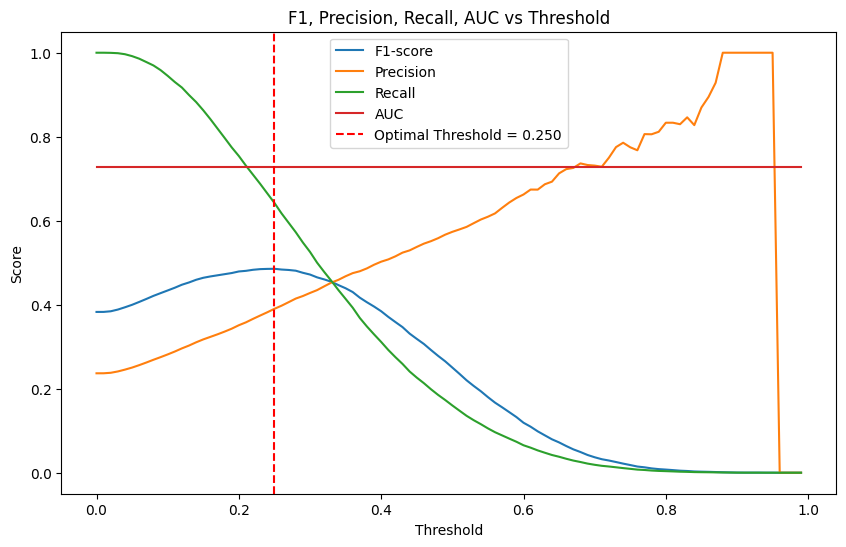

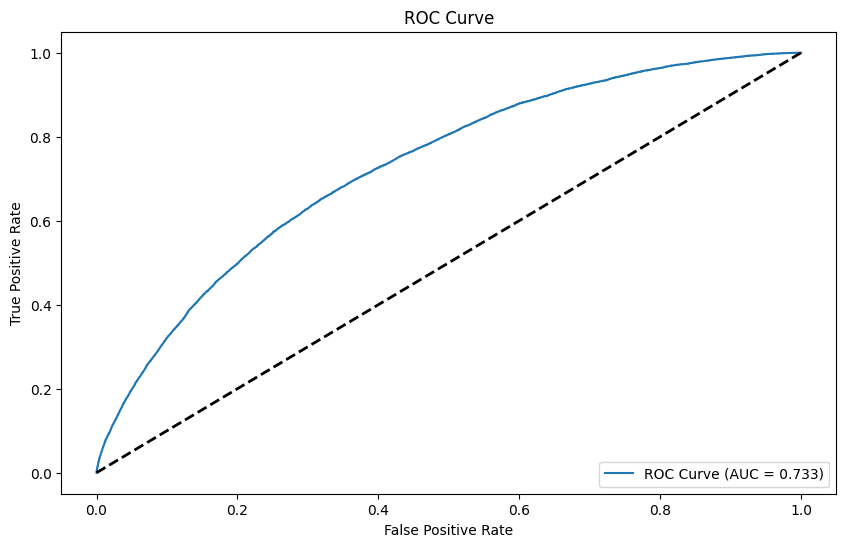

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# K-fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 임계값 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)

# 각 fold에서의 최적 임계값을 저장할 리스트
optimal_thresholds = []

# 각 fold에서 성능 지표를 저장할 리스트 초기화
f1_scores_fold = []
precisions_fold = []
recalls_fold = []
auc_scores_fold = []

# 각 fold에 대해 교차 검증 수행
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # CatBoost 모델 학습
    cat_model = cat_model = CatBoostClassifier(random_state=42, iterations=10000, learning_rate= 0.01, task_type="GPU", devices='0')
    cat_model.fit(X_train_fold, y_train_fold)

    # 예측 확률 계산
    cat_test_proba = cat_model.predict_proba(X_test_fold)[:, 1]

    # 각 임계값에서의 F1, Precision, Recall 저장을 위한 리스트 초기화
    f1_scores = []
    precisions = []
    recalls = []
    auc_scores = []

    # 각 임계값에서 성능 지표 계산
    for threshold in thresholds:
        # 임계값에 따른 예측 결과 계산
        cat_test_pred_threshold = (cat_test_proba >= threshold).astype(int)

        # F1, Precision, Recall 계산
        f1 = f1_score(y_test_fold, cat_test_pred_threshold)
        precision = precision_score(y_test_fold, cat_test_pred_threshold)
        recall = recall_score(y_test_fold, cat_test_pred_threshold)
        auc = roc_auc_score(y_test_fold, cat_test_proba)

        # 결과 저장
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        auc_scores.append(auc)

    # F1-score가 최대인 임계값 찾기
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # 각 fold에서 최적 임계값 및 성능 지표 저장
    optimal_thresholds.append(optimal_threshold)
    f1_scores_fold.append(f1_scores[optimal_idx])
    precisions_fold.append(precisions[optimal_idx])
    recalls_fold.append(recalls[optimal_idx])
    auc_scores_fold.append(auc_scores[optimal_idx])

# 최적 임계값 평균 계산
mean_optimal_threshold = np.mean(optimal_thresholds)
mean_f1_score = np.mean(f1_scores_fold)
mean_precision = np.mean(precisions_fold)
mean_recall = np.mean(recalls_fold)
mean_auc_score = np.mean(auc_scores_fold)

print(f"평균 최적 임계값: {mean_optimal_threshold:.3f}")
print(f"평균 최적 임계값에서의 F1-score: {mean_f1_score:.3f}")
print(f"평균 최적 임계값에서의 Precision: {mean_precision:.3f}")
print(f"평균 최적 임계값에서의 Recall: {mean_recall:.3f}")
print(f"평균 최적 임계값에서의 AUC: {mean_auc_score:.3f}")

# 마지막 fold에 대한 F1, Precision, Recall, AUC을 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, auc_scores, label='AUC')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, Recall, AUC vs Threshold')
plt.legend(loc='best')
plt.show()

# ROC Curve 시각화 (마지막 fold 기준)
fpr, tpr, _ = roc_curve(y_test_fold, cat_test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {mean_auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
